In [ ]:
import autograd 

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

import structure_model_lib 
import dp_modeling_lib
import data_utils

import paragami

import optimization_lib as opt_lib

from itertools import permutations

import matplotlib.pyplot as plt
%matplotlib inline  

import vittles

from copy import deepcopy

In [2]:
np.random.seed(53453)

# Draw data

In [3]:
n_obs = 50
n_loci = 40
n_pop = 4

# population allele frequencies
true_pop_allele_freq = np.random.random((n_loci, n_pop))

# individual admixtures
true_ind_admix_propn = np.random.dirichlet(np.ones(n_pop) / n_pop, size = (n_obs))

In [4]:
clustering_indx = data_utils.cluster_admix_get_indx(true_ind_admix_propn)
true_ind_admix_propn = true_ind_admix_propn[clustering_indx, :]

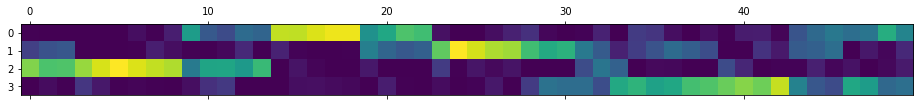

In [5]:
plt.matshow(true_ind_admix_propn.T)

In [6]:
g_obs = data_utils.draw_data(true_pop_allele_freq, true_ind_admix_propn)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [8]:
k_approx = n_pop

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (40, 4, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_propn_mean] = NumericArrayPattern (50, 3) (lb=-inf, ub=inf)
	[ind_mix_stick_propn_info] = NumericArrayPattern (50, 3) (lb=0.0001, ub=inf)


## Initialize 

In [11]:
vb_params_dict = opt_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict)

In [12]:
# take a look at init 
e_ind_admix = dp_modeling_lib.get_e_cluster_probabilities(
                    vb_params_dict['ind_mix_stick_propn_mean'], 
                    vb_params_dict['ind_mix_stick_propn_info'],
                    gh_loc, gh_weights)

e_pop_freq = dp_modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])

In [13]:
perm = data_utils.find_min_perm(e_pop_freq, true_pop_allele_freq, axis = 1)

e_pop_freq = e_pop_freq[:, perm]
e_ind_admix = e_ind_admix[:, perm]

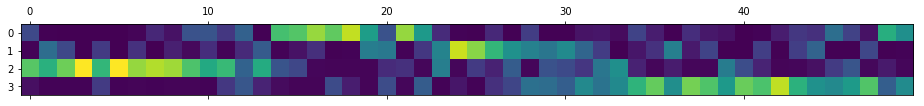

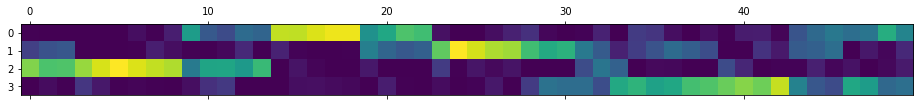

In [14]:
plt.matshow(e_ind_admix.T); 
plt.matshow(true_ind_admix_propn.T);

# Set up model

In [15]:
# get loss as a function of vb parameters
get_free_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=structure_model_lib.get_kl, 
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 1)

get_free_vb_params_loss_cached = \
    lambda x : get_free_vb_params_loss(g_obs, x, prior_params_dict, gh_loc, gh_weights, 
                                      true_pop_allele_freq = None, 
                                      true_ind_admix_propn = None)

In [16]:
init_vb_free_params = vb_params_paragami.flatten(vb_params_dict, free = True)

In [17]:
structure_model_lib.get_kl(g_obs, vb_params_dict,
                   prior_params_dict, gh_loc, gh_weights)

5278.532804627066

In [18]:
get_free_vb_params_loss_cached(init_vb_free_params)

5278.532804627066

In [19]:
vb_opt_free_params = opt_lib.optimize_full(get_free_vb_params_loss_cached, init_vb_free_params,
                    bfgs_max_iter = 50, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

running bfgs ... 
Iter 0: f = 5278.53280463
Iter 1: f = 5090.16881964
Iter 2: f = 4811.52285237
Iter 3: f = 4371.95372216
Iter 4: f = 3957.89086637
Iter 5: f = 3686.31815002
Iter 6: f = 3476.78734549
Iter 7: f = 3398.62470542
Iter 8: f = 3322.20253975
Iter 9: f = 3279.05381038
Iter 10: f = 3246.53826724
Iter 11: f = 3212.94761317
Iter 12: f = 3188.52480405
Iter 13: f = 3169.61136875
Iter 14: f = 3155.53109695
Iter 15: f = 3142.20584773
Iter 16: f = 3128.94437564
Iter 17: f = 3121.70687488
Iter 18: f = 3111.71129092
Iter 19: f = 3099.97351407
Iter 20: f = 3093.69074255
Iter 21: f = 3085.81978002
Iter 22: f = 3080.33470928
Iter 23: f = 3072.10977800
Iter 24: f = 3065.50443430
Iter 25: f = 3064.53344856
Iter 26: f = 3070.20199586
Iter 27: f = 3061.67972474
Iter 28: f = 3057.11637487
Iter 29: f = 3052.46468589
Iter 30: f = 3045.63951030
Iter 31: f = 3045.82531021
Iter 32: f = 3041.14171365
Iter 33: f = 3043.15322033
Iter 34: f = 3039.35625892
Iter 35: f = 3036.78947836
Iter 36: f = 3033.95

In [20]:
vb_opt_dict = vb_params_paragami.fold(vb_opt_free_params, free=True)

In [21]:
ind_mix_stick_propn_mean = vb_opt_dict['ind_mix_stick_propn_mean']
ind_mix_stick_propn_info = vb_opt_dict['ind_mix_stick_propn_info']
pop_freq_beta_params = vb_opt_dict['pop_freq_beta_params']

In [22]:
e_pop_allele_freq = pop_freq_beta_params[:, :, 0] / pop_freq_beta_params.sum(axis=2)

In [23]:
perm_best = data_utils.find_min_perm(e_pop_allele_freq, true_pop_allele_freq, axis = 1)

([array([6., 4., 3., 6., 2., 5., 3., 0., 4., 7.]),
  array([ 7.,  0.,  6.,  2.,  2.,  3.,  5.,  0.,  5., 10.]),
  array([ 8.,  1.,  2.,  5.,  1.,  4.,  2.,  3.,  4., 10.]),
  array([5., 2., 4., 5., 4., 5., 2., 2., 3., 8.])],
 array([0.04033442, 0.13150695, 0.22267948, 0.31385201, 0.40502454,
        0.49619707, 0.5873696 , 0.67854213, 0.76971466, 0.86088719,
        0.95205972]),
 <a list of 4 Lists of Patches objects>)

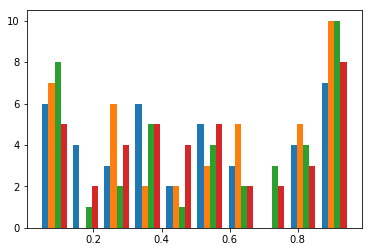

In [24]:
plt.hist(e_pop_allele_freq)

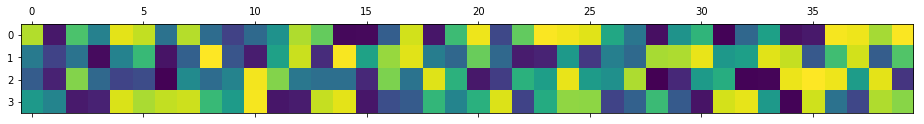

In [25]:
plt.matshow(e_pop_allele_freq[:, perm_best].T)

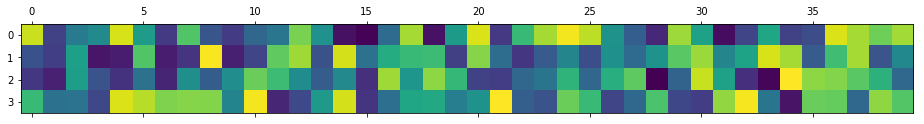

In [26]:
plt.matshow(true_pop_allele_freq.T)

In [27]:
e_ind_admix = dp_modeling_lib.get_e_cluster_probabilities(
                        ind_mix_stick_propn_mean, ind_mix_stick_propn_info,
                        gh_loc, gh_weights)[:, perm_best]

In [28]:
e_ind_admix.argmax(axis=1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3,
       1, 3, 3, 1, 0, 0])

In [29]:
true_ind_admix_propn.argmax(axis=1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       0, 0, 3, 3, 0, 0])

In [30]:
np.mean(e_ind_admix.argmax(axis=1) == \
       true_ind_admix_propn.argmax(axis=1))

0.82

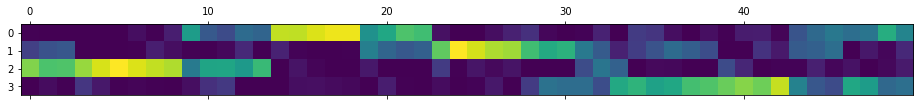

In [31]:
plt.matshow(true_ind_admix_propn.T)

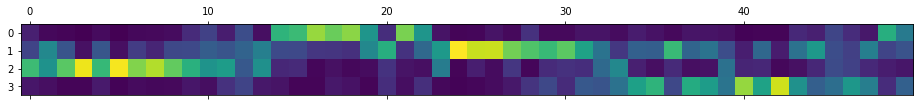

In [32]:
plt.matshow(e_ind_admix.T)

# Parametric sensitivity

## Get linear sensitivity object

In [33]:
get_kl_from_vb_free_prior_free = paragami.FlattenFunctionInput(original_fun=structure_model_lib.get_kl, 
                                    patterns = [vb_params_paragami, prior_params_paragami],
                                    free = True,
                                    argnums = [1, 2])

In [34]:
vb_sens = \
    vittles.HyperparameterSensitivityLinearApproximation(
        objective_fun = lambda x, y: get_kl_from_vb_free_prior_free(g_obs, x, y, gh_loc, gh_weights),
        opt_par_value = vb_opt_free_params, 
        hyper_par_value = prior_params_paragami.flatten(prior_params_dict, free=True),
        validate_optimum=False,
        hessian_at_opt=None,
        cross_hess_at_opt=None,
        factorize_hessian=True,
        hyper_par_objective_fun=None,
        grad_tol=1e-8)

In [35]:
hessian_at_opt = vb_sens.get_hessian_at_opt()

## Perturb and re-optimize

In [36]:
prior_perturbed_dict = deepcopy(prior_params_dict)

In [37]:
prior_perturbed_dict['dp_prior_alpha'] = 8

In [38]:
perturbed_objective = \
    lambda x : get_free_vb_params_loss(g_obs, x, 
                                       prior_perturbed_dict, gh_loc, gh_weights, 
                                      true_pop_allele_freq = None, 
                                      true_ind_admix_propn = None)

In [39]:
pert_vb_free_params = \
    opt_lib.optimize_full(perturbed_objective, 
                    deepcopy(vb_opt_free_params),
                    bfgs_max_iter = 0, 
                    netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8, 
                    init_hessian = deepcopy(hessian_at_opt))


 running preconditioned newton; iter =  0
setting preconditioner with hessian: 
running newton steps
Iter 0: f = 3313.79646157
Iter 1: f = 3294.75690313
Iter 2: f = 3262.19673815
Iter 3: f = 3219.50629657
Iter 4: f = 3203.03242454
Iter 5: f = 3199.81180244
Iter 6: f = 3195.20130389
Iter 7: f = 3194.59880275
Iter 8: f = 3193.53789040
Iter 9: f = 3193.47110743
Iter 10: f = 3193.40338605
Iter 11: f = 3193.39371838
Iter 12: f = 3193.39124890
Iter 13: f = 3193.39121751
Iter 14: f = 3193.39121736
Iter 15: f = 3193.39121736
Iter 16: f = 3193.39121736
         Current function value: 3193.391217
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 16
         Hessian evaluations: 0
Iter 0: x_diff = 402.58563535478976, f_diff = 120.40524421619784, grad_l1 = 6.905592760951336e-07

 running preconditioned newton; iter =  1
setting preconditioner with hessian: 
running newton steps
Iter 0: f = 3193.39121736
Iter 1: f = 3193.39121736
         Current function va

In [40]:
# non-zero if optimization went somewhere
np.max(np.abs(pert_vb_free_params - vb_opt_free_params))

2.3946800736836873

### linear response

In [41]:
lr_vb_free_params = \
    vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami.flatten(prior_perturbed_dict, free = True))

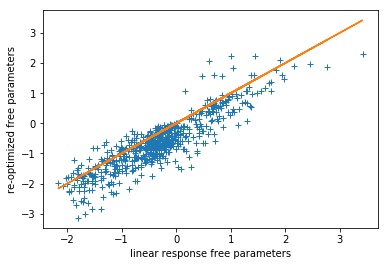

In [46]:
plt.plot(lr_vb_free_params - vb_opt_free_params, 
         pert_vb_free_params - vb_opt_free_params, '+')

plt.plot(lr_vb_free_params - vb_opt_free_params, 
        lr_vb_free_params - vb_opt_free_params, '-')

plt.ylabel('re-optimized free parameters')
plt.xlabel('linear response free parameters')

# Perturb for a range of alphas

In [43]:
alpha_vec = np.arange(1, 12)

In [44]:
pert_vb_free_params_array = np.zeros((len(alpha_vec), len(vb_opt_free_params)))
lr_vb_free_params_array = np.zeros((len(alpha_vec), len(vb_opt_free_params)))

for i in range(len(alpha_vec)): 
    print('###########################\n')
    print('optimizing alpha = {}\n'.format(alpha_vec[i]))
    print('###########################\n')
    # get prior perturbation 
    prior_perturbed_dict = deepcopy(prior_params_dict)
    prior_perturbed_dict['dp_prior_alpha'] = alpha_vec[i]
    
    # get perturbed objective 
    perturbed_objective = \
        lambda x : get_free_vb_params_loss(g_obs, x, 
                                           prior_perturbed_dict, gh_loc, gh_weights, 
                                          true_pop_allele_freq = None, 
                                          true_ind_admix_propn = None)
    # optimize 
    pert_vb_free_params = \
        opt_lib.optimize_full(perturbed_objective, 
                        deepcopy(vb_opt_free_params),
                        bfgs_max_iter = 0, 
                        netwon_max_iter = 50,
                        max_precondition_iter = 10,
                        gtol=1e-8, ftol=1e-8, xtol=1e-8, 
                        init_hessian = deepcopy(hessian_at_opt))
    
    # get linear response
    lr_vb_free_params = \
        vb_sens.predict_opt_par_from_hyper_par(
            prior_params_paragami.flatten(prior_perturbed_dict, free = True))
    
    pert_vb_free_params_array[i, :] = pert_vb_free_params
    lr_vb_free_params_array[i, :] = lr_vb_free_params
    

###########################

optimizing alpha = 1

###########################


 running preconditioned newton; iter =  0
setting preconditioner with hessian: 
running newton steps
Iter 0: f = 2862.73191504
Iter 1: f = 2855.07068280
Iter 2: f = 2841.81079913
Iter 3: f = 2824.50254138
Iter 4: f = 2811.83304288
Iter 5: f = 2806.53416988
Iter 6: f = 2806.06218721
Iter 7: f = 2805.50263781
Iter 8: f = 2805.47317477
Iter 9: f = 2805.44631836
Iter 10: f = 2805.44498009
Iter 11: f = 2805.44486524
Iter 12: f = 2805.44486440
Iter 13: f = 2805.44486440
Iter 14: f = 2805.44486440
         Current function value: 2805.444864
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 14
         Hessian evaluations: 0
Iter 0: x_diff = 430.4190674743975, f_diff = 57.28705064253654, grad_l1 = 3.25829939356896e-06

 running preconditioned newton; iter =  1
setting preconditioner with hessian: 
running newton steps
Iter 0: f = 2805.44486440
Iter 1: f = 2805.44486440
     

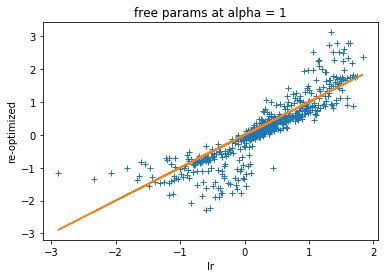

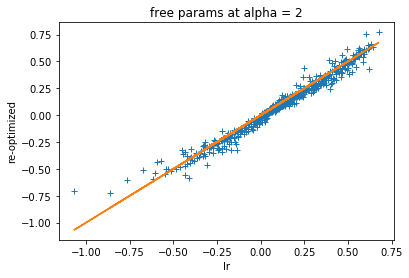

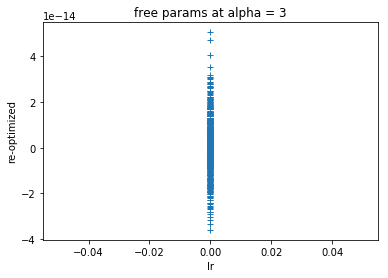

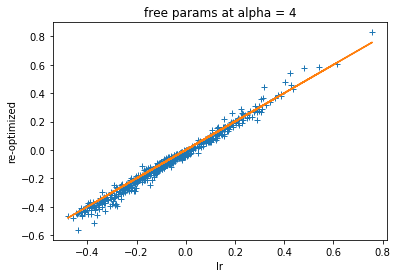

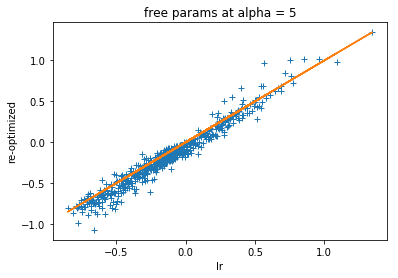

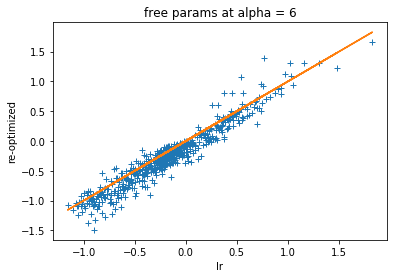

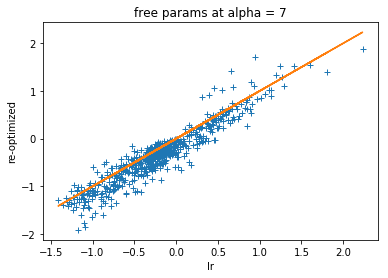

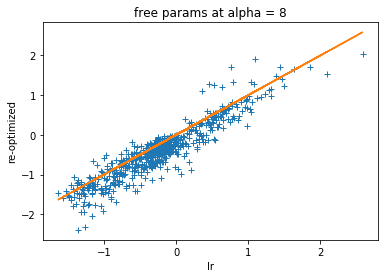

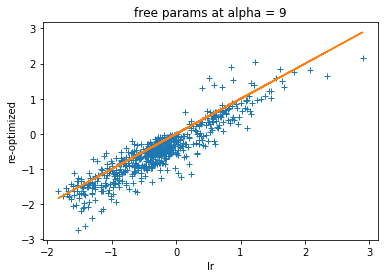

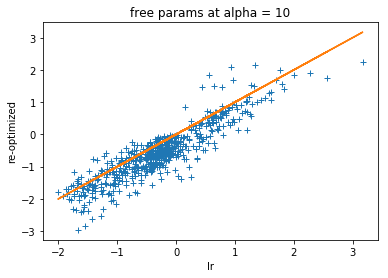

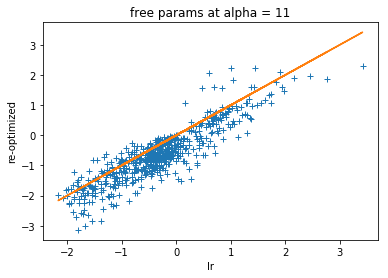

In [53]:
# check results:
for i in range(len(alpha_vec)): 
    plt.figure()
    plt.plot(lr_vb_free_params_array[i, :] - vb_opt_free_params, 
            pert_vb_free_params_array[i, :] - vb_opt_free_params, '+')
    plt.plot(lr_vb_free_params_array[i, :] - vb_opt_free_params, 
            lr_vb_free_params_array[i, :] - vb_opt_free_params, '-')
    
    plt.title('free params at alpha = {}'.format(alpha_vec[i]))
    plt.xlabel('lr')
    plt.ylabel('re-optimized')

# check how vb expectations change

In [81]:
def get_vb_expectations(vb_free_params, vb_params_paragami, true_pop_allele_freq): 
    # get vb dict 
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free=True)
    
    # get popoulation frequencies
    e_pop_allele_freq = dp_modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    # find minimizing permutation 
    perm = data_utils.find_min_perm(e_pop_allele_freq, true_pop_allele_freq, axis = 1)
    
    # get individual admixutures
    e_ind_admix = dp_modeling_lib.get_e_cluster_probabilities(
                        vb_params_dict['ind_mix_stick_propn_mean'], 
                        vb_params_dict['ind_mix_stick_propn_info'],
                        gh_loc, gh_weights)[:, perm]
    
    return e_ind_admix, e_pop_allele_freq[:, perm]

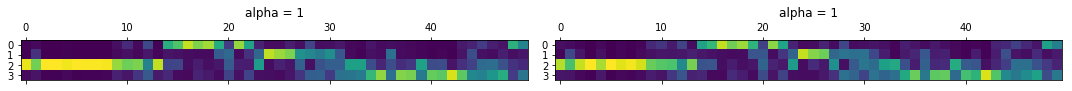

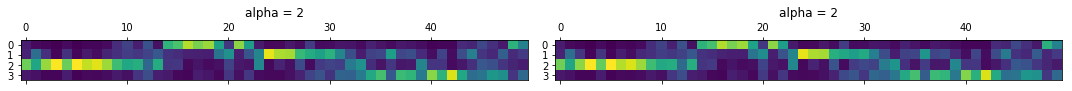

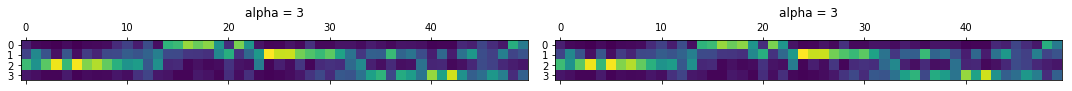

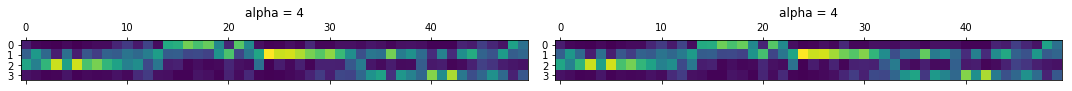

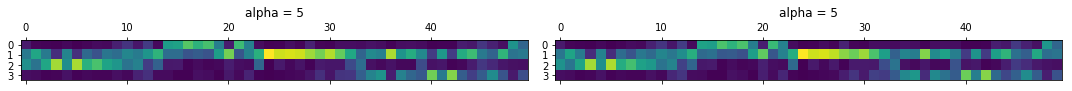

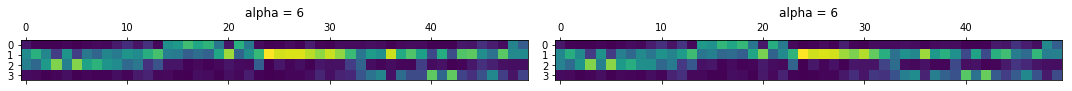

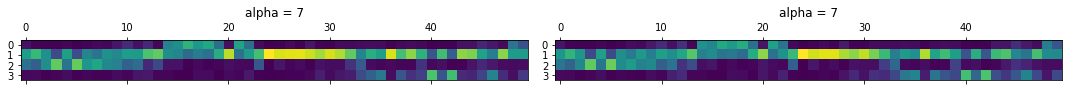

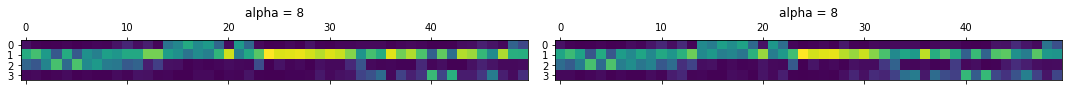

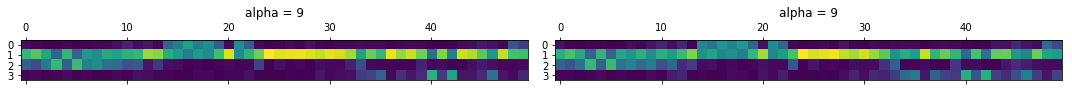

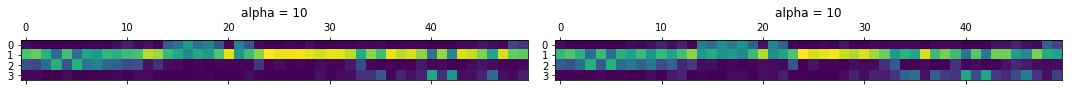

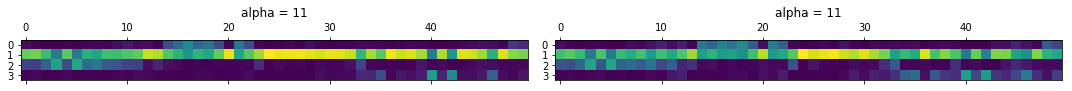

In [88]:
opt_e_ind_admix, opt_e_pop_allele_freq = get_vb_expectations(vb_opt_free_params, 
                                                                vb_params_paragami, 
                                                                true_pop_allele_freq)

pert_e_ind_admix_array = np.zeros((len(alpha_vec), len(opt_e_ind_admix.flatten())))
lr_e_ind_admix_array = np.zeros((len(alpha_vec), len(opt_e_ind_admix.flatten())))

pert_e_pop_allele_freq_array = np.zeros((len(alpha_vec), len(opt_e_pop_allele_freq.flatten())))
lr_e_pop_allele_freq_array = np.zeros((len(alpha_vec), len(opt_e_pop_allele_freq.flatten())))

for i in range(len(alpha_vec)): 
    pert_e_ind_admix, pert_e_pop_allele_freq = \
                    get_vb_expectations(pert_vb_free_params_array[i, :], 
                                                vb_params_paragami, 
                                                true_pop_allele_freq)
    
    lr_e_ind_admix, lr_e_pop_allele_freq = \
                    get_vb_expectations(lr_vb_free_params_array[i, :], 
                                                vb_params_paragami, 
                                                true_pop_allele_freq)
    
    _, axarr = plt.subplots(1, 2, figsize = (15, 15))
    axarr[0].matshow(pert_e_ind_admix.T)
    axarr[1].matshow(lr_e_ind_admix.T)
    axarr[0].set_title('alpha = {}\n'.format(alpha_vec[i]))
    axarr[1].set_title('alpha = {}\n'.format(alpha_vec[i]))
    
    plt.tight_layout()
    
    pert_e_ind_admix_array[i, :] = pert_e_ind_admix.flatten()
    lr_e_ind_admix_array[i, :] = lr_e_ind_admix.flatten()
    
    pert_e_pop_allele_freq_array[i, :] = pert_e_pop_allele_freq.flatten()
    lr_e_pop_allele_freq_array[i, :] = lr_e_pop_allele_freq.flatten()

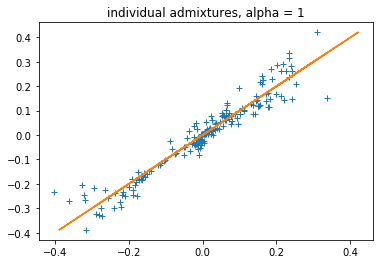

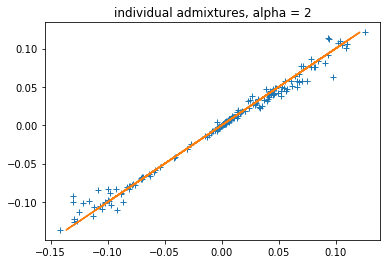

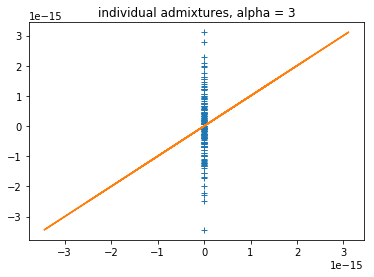

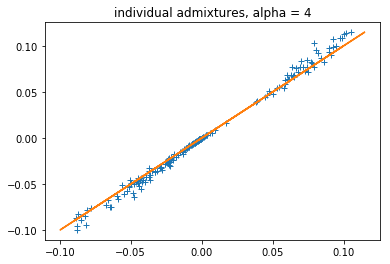

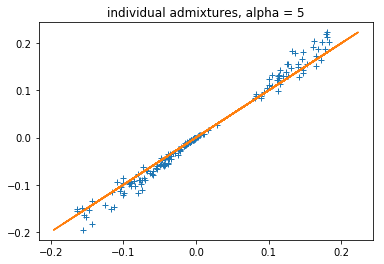

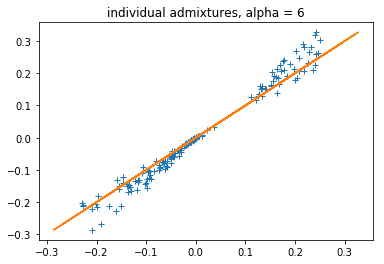

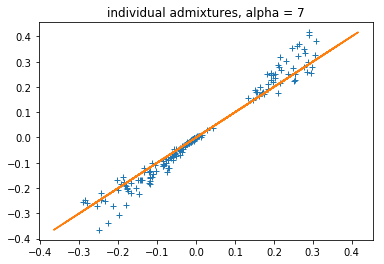

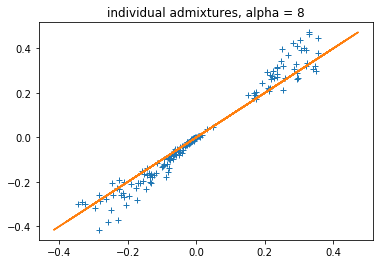

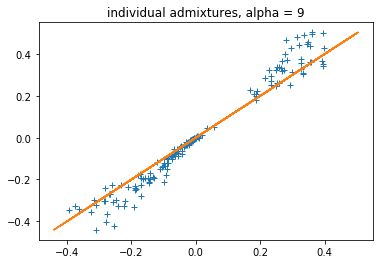

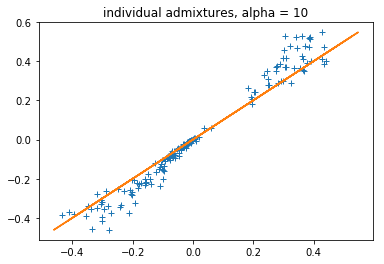

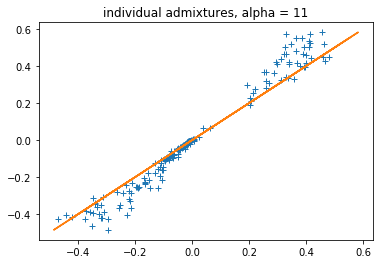

In [94]:
for i in range(len(alpha_vec)): 
    plt.figure()
    plt.plot(lr_e_ind_admix_array[i, :] - opt_e_ind_admix.flatten(), 
            pert_e_ind_admix_array[i, :] - opt_e_ind_admix.flatten(), '+')
    plt.plot(pert_e_ind_admix_array[i, :] - opt_e_ind_admix.flatten(), 
            pert_e_ind_admix_array[i, :] - opt_e_ind_admix.flatten(), '-')
    plt.title('individual admixtures, alpha = {}'.format(alpha_vec[i]))
    
    plt.xlabel('lr')
    plt.ylabel('re-opt')

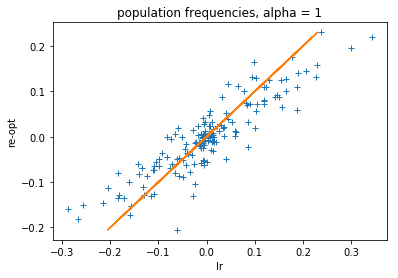

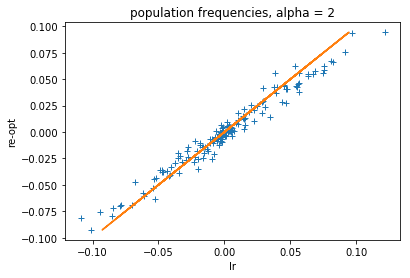

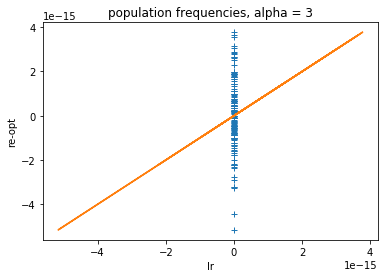

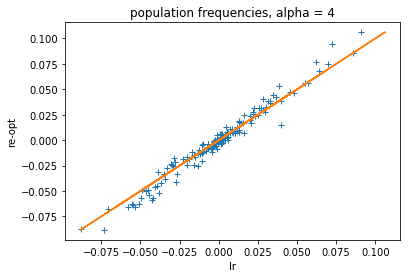

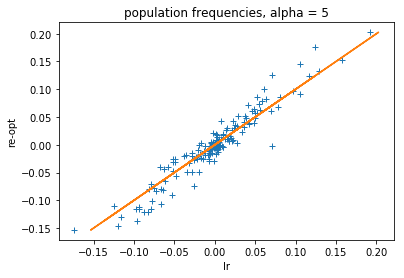

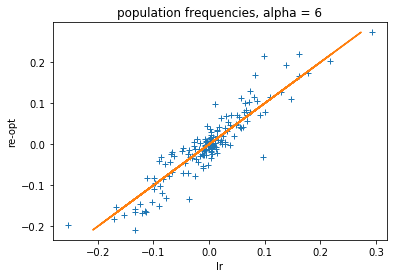

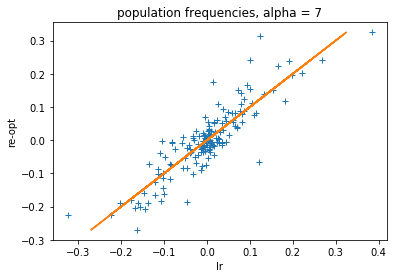

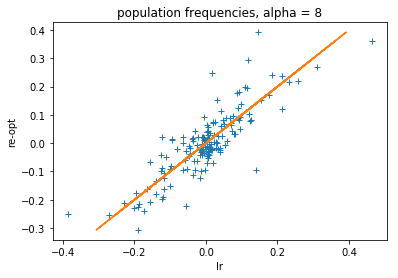

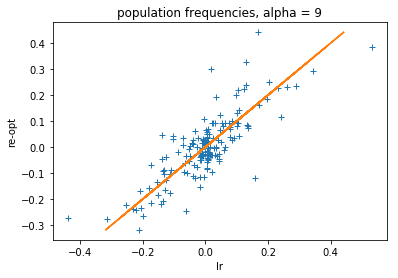

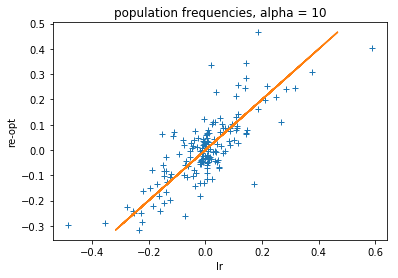

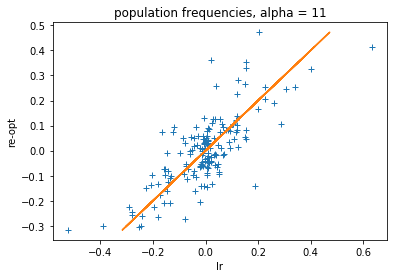

In [97]:
for i in range(len(alpha_vec)): 
    plt.figure()
    plt.plot(lr_e_pop_allele_freq_array[i, :] - opt_e_pop_allele_freq.flatten(), 
            pert_e_pop_allele_freq_array[i, :] - opt_e_pop_allele_freq.flatten(), '+')
    plt.plot(pert_e_pop_allele_freq_array[i, :] - opt_e_pop_allele_freq.flatten(), 
            pert_e_pop_allele_freq_array[i, :] - opt_e_pop_allele_freq.flatten(), '-')
    plt.title('population frequencies, alpha = {}'.format(alpha_vec[i]))
    plt.xlabel('lr')
    plt.ylabel('re-opt')